
# MGSC 661 — Predicting Startup Exits (Preliminary Findings Notebook)

This notebook produces quick, defensible preliminary findings on **predicting acquisitions (exits)**
from an investment/company dataset. It:
- inspects the dataset, 
- constructs (or detects) a binary target for **acquired vs. not**, 
- handles class imbalance (via **SMOTE** if available; otherwise class weighting),
- trains a baseline and a **Logistic Regression** model,
- and reports interpretability artifacts (coefficients and permutation importance).

> Context: The project frames acquisition prediction as a **binary classification** problem with class imbalance; we therefore evaluate ROC-AUC and PR-AUC and prefer transparent, explainable baselines to start.



### Project Abstract (reference)
From the course PoC abstract, we investigate logistic regression (and related ML) to predict the likelihood of a startup **achieving a successful exit (acquisition)** using Crunchbase-style company & investment data. We treat this as a **binary classification** problem with **class imbalance** and use resampling (e.g., SMOTE) and feature analysis to identify drivers of acquisition outcomes.


In [ ]:
# ---- Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.inspection import permutation_importance

# Imbalance handling
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_OK = True
except Exception:
    IMB_OK = False

DATA_PATH = Path('/Users/othmanezizi/gp_mgsc661/investments_VC.csv')  # Provided by the user
assert DATA_PATH.exists(), f"Data not found at {DATA_PATH}"

# Read CSV and clean column names + funding amounts
df = pd.read_csv(DATA_PATH, encoding='latin1')

# Fix column names (strip whitespace)
df.columns = df.columns.str.strip()

# Fix funding_total_usd: remove commas and handle " - " for missing values
df['funding_total_usd'] = df['funding_total_usd'].astype(str).str.strip().str.replace(',', '')
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'].replace(['-', ''], np.nan), errors='coerce')

df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4000000.0,operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|iPhone|Apps|Mobile|iOS|E-Commerce|,Electronics,1500000.0,operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:

# ---- Quick dataset peek
print("Shape:", df.shape)
print("\nColumns:\n", list(df.columns))
print("\nNon-null counts:\n")
print(df.notnull().sum().sort_values(ascending=False).head(30))

display(df.sample(min(5, len(df)), random_state=42))


Shape: (54294, 39)

Columns:
 ['permalink', 'name', 'homepage_url', 'category_list', 'market', 'funding_total_usd', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']

Non-null counts:

permalink               49438
secondary_market        49438
convertible_note        49438
debt_financing          49438
angel                   49438
grant                   49438
private_equity          49438
post_ipo_equity         49438
post_ipo_debt           49438
product_crowdfunding    49438
equity_crowdfunding     49438
round_A                 49438
round_B                 4

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
30166,/organization/omaze,Omaze,http://www.omaze.com,|Curated Web|,Curated Web,1000000.0,operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12481,/organization/dvdplay,DVDPlay,http://www.dvdplay.com,|Automated Kiosk|Manufacturing|Entertainment|,Entertainment,20000000.0,operating,USA,CA,SF Bay Area,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45753,/organization/veracyte,Veracyte,http://www.veracyte.com,|Health Care|Biotechnology|,Health Care,70950000.0,operating,USA,CA,SF Bay Area,...,0.0,0.0,0.0,28000000.0,28000000.0,0.0,0.0,0.0,0.0,0.0
25853,/organization/medgenics,Medgenics,http://www.medgenics.com,|Biotechnology|,Biotechnology,35226066.0,operating,USA,CA,SF Bay Area,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9194,/organization/cognitive-match,Cognitive Match,http://www.cognitivematch.com,|Personalization|Advertising|,Advertising,10150000.0,acquired,USA,NY,New York City,...,0.0,0.0,1650000.0,2500000.0,6000000.0,0.0,0.0,0.0,0.0,0.0



## Target construction / detection
We aim to build **Acquired (1) vs Not Acquired (0)**. The code below attempts to detect a suitable
column by name or derive it from status-like columns. It uses common synonyms like `"acquired"`, `"exit"`, `"status"`.
If none is found, it tries to create a target from text-based statuses (e.g., `"acquired"`, `"acquisition"`).


In [65]:

# ---- Try to detect or construct a binary target
import re

def find_target_column(columns):
    # Heuristic: likely candidates by name
    candidates = [
        'acquired', 'is_acquired', 'acquisition', 'acq', 'exit', 'exited',
        'acquired_flag', 'target', 'label', 'y'
    ]
    # Also look for status-like columns from which we can derive acquisition
    status_like = []
    for c in columns:
        lc = c.lower()
        if any(tok in lc for tok in ['status', 'state', 'outcome', 'result']):
            status_like.append(c)
    for c in columns:
        if c.lower() in candidates:
            return c, None
    return None, status_like

target_col, status_like_cols = find_target_column(df.columns)

def coerce_to_binary(series):
    # Accept a few common encodings
    if series.dropna().isin([0,1]).all():
        return series.astype(int)
    # Strings: map 'acquired' variants to 1, else 0
    def map_val(v):
        if pd.isna(v):
            return np.nan
        s = str(v).strip().lower()
        # Positive acquisition indicators
        if re.search(r'\b(acq|acquired|acquisition|bought|merged)\b', s):
            return 1
        # Negative (operating/closed) -> 0
        if re.search(r'\b(closed|dead|operating|active|private|unknown|none|no)\b', s):
            return 0
        # Fallback: try to cast to int
        try:
            f = float(s)
            if f in (0.0, 1.0):
                return int(f)
        except Exception:
            pass
        return np.nan
    mapped = series.apply(map_val)
    return mapped

y = None
y_source = None

if target_col is not None:
    y_try = coerce_to_binary(df[target_col])
    if y_try.notnull().sum() >= max(50, int(0.05*len(y_try))):  # must have enough labels
        y = y_try
        y_source = f"Detected direct target column: '{target_col}'"
else:
    # Derive from status-like columns if possible
    for sc in status_like_cols:
        y_try = coerce_to_binary(df[sc])
        if y_try.notnull().sum() >= max(50, int(0.05*len(y_try))):
            y = y_try
            y_source = f"Derived from status-like column: '{sc}'"
            break

if y is None:
    raise ValueError(
        "Could not detect or derive a usable binary target. "
        "Please add a column (e.g., 'acquired' in {0,1} or status text with 'acquired')."
    )

print("Target source:", y_source)
print("Positives (acquired=1):", int((y==1).sum()))
print("Negatives (not acquired=0):", int((y==0).sum()))
print("Missing target labels:", int(y.isna().sum()))


Target source: Derived from status-like column: 'status'
Positives (acquired=1): 3692
Negatives (not acquired=0): 44432
Missing target labels: 6170


In [66]:

# ---- Class imbalance check
y_valid = y.dropna()
pos_rate = y_valid.mean()
print(f"Positive rate (acquired=1): {pos_rate:.4f} (n={len(y_valid)})")


Positive rate (acquired=1): 0.0767 (n=48124)



## Feature preparation
We exclude the detected target column from features, drop fully-NA columns, and split numerical vs categorical automatically.


## Temporal Leakage Prevention
To avoid temporal leakage, we:
1. **Define a prediction cutoff date** (e.g., 2014-01-01) representing when predictions would be made
2. **Remove direct temporal features** that leak information (`founded_year`, `founded_at`, dates)
3. **Create time-based features** computed as of the cutoff date (company age, time since funding, etc.)
4. **Use time-based train/test split** to simulate real-world deployment

In [67]:
# ---- Temporal leakage prevention: Create time-based features
from datetime import datetime

# Define prediction cutoff date (companies founded/funded before this date)
PREDICTION_CUTOFF = pd.to_datetime('2014-01-01')

# Convert date columns to datetime
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Create time-based features (as of cutoff date)
# Use .where() to handle NaT (Not a Time) values properly
df['company_age_days'] = (PREDICTION_CUTOFF - df['founded_at']).dt.days
df['days_since_first_funding'] = (PREDICTION_CUTOFF - df['first_funding_at']).dt.days
df['days_since_last_funding'] = (PREDICTION_CUTOFF - df['last_funding_at']).dt.days
df['funding_duration_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

# Calculate funding velocity (total funding / company age)
# Replace invalid values (negative, zero, or NaN age) with NaN to be imputed later
df['funding_velocity'] = df['funding_total_usd'] / df['company_age_days']

# CRITICAL: Replace infinity and very large values with NaN (will be imputed)
# This happens when company_age_days is 0 or very small
df['funding_velocity'] = df['funding_velocity'].replace([np.inf, -np.inf], np.nan)

# Set negative time values to NaN (these indicate data quality issues)
for col in ['company_age_days', 'days_since_first_funding', 'days_since_last_funding', 'funding_duration_days']:
    if col in df.columns:
        df[col] = df[col].where(df[col] >= 0, np.nan)

# CRITICAL: Remove direct temporal features that cause leakage
temporal_leakage_cols = [
    'founded_at', 'first_funding_at', 'last_funding_at',
    'founded_month', 'founded_quarter', 'founded_year'
]
print(f"Removing temporal leakage columns: {temporal_leakage_cols}")

# Also remove identifier columns (not predictive)
identifier_cols = ['permalink', 'name', 'homepage_url']

print(f"\nNew time-based features created:")
print(f"  - company_age_days")
print(f"  - days_since_first_funding")
print(f"  - days_since_last_funding")
print(f"  - funding_duration_days")
print(f"  - funding_velocity")

print(f"\nSample of new features:")
print(df[['company_age_days', 'days_since_first_funding', 'days_since_last_funding', 
    'funding_duration_days', 'funding_velocity']].describe())

# Check for any remaining infinity values
inf_check = df[['company_age_days', 'days_since_first_funding', 'days_since_last_funding', 
                'funding_duration_days', 'funding_velocity']].apply(lambda x: np.isinf(x).sum())
print(f"\nInfinity values check (should all be 0):")
print(inf_check)

Removing temporal leakage columns: ['founded_at', 'first_funding_at', 'last_funding_at', 'founded_month', 'founded_quarter', 'founded_year']

New time-based features created:
  - company_age_days
  - days_since_first_funding
  - days_since_last_funding
  - funding_duration_days
  - funding_velocity

Sample of new features:
       company_age_days  days_since_first_funding  days_since_last_funding  \
count      37513.000000              41398.000000             35875.000000   
mean        2514.434329               1253.742741              1043.912307   
std         3578.766977               1114.652201              1046.784793   
min            0.000000                  0.000000                 0.000000   
25%          731.000000                426.000000               292.000000   
50%         1574.000000                999.000000               762.000000   
75%         3197.000000               1784.000000              1484.000000   
max        83640.000000              33725.000000  

In [68]:
# ---- Build X (features) and align with y
if target_col is not None and y_source.startswith("Detected direct"):
    target_name = target_col
elif y_source and 'Derived' in y_source:
    target_name = y_source.split("'")[1]
else:
    target_name = None

X = df.copy()
if target_name and target_name in X.columns:
    X = X.drop(columns=[target_name])

# CRITICAL: Remove temporal leakage and identifier columns
temporal_leakage_cols = [
    'founded_at', 'first_funding_at', 'last_funding_at',
    'founded_month', 'founded_quarter', 'founded_year'
]
identifier_cols = ['permalink', 'name', 'homepage_url']

cols_to_remove = temporal_leakage_cols + identifier_cols
cols_to_remove = [c for c in cols_to_remove if c in X.columns]
X = X.drop(columns=cols_to_remove)

print(f"Removed {len(cols_to_remove)} leakage/identifier columns: {cols_to_remove}")

# Remove columns that are all NA or constant
nunique = X.nunique(dropna=False)
keep_cols = nunique[nunique > 1].index.tolist()
X = X[keep_cols]

# Identify types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Train/valid split (drop rows with missing target)
mask = y.notnull()
X_ = X[mask].copy()
y_ = y[mask].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_, y_, test_size=0.2, random_state=42, stratify=y_
)

# Preprocess pipeline
from sklearn.impute import SimpleImputer

numeric_tf = Pipeline(steps=[
    ("impute",       SimpleImputer(strategy="median")),
    ("scale",        StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("impute",       SimpleImputer(strategy="most_frequent")),
    ("onehot",       OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_tf, numeric_cols),
    ("cat", categorical_tf, categorical_cols)
])

Removed 9 leakage/identifier columns: ['founded_at', 'first_funding_at', 'last_funding_at', 'founded_month', 'founded_quarter', 'founded_year', 'permalink', 'name', 'homepage_url']

Numeric columns: 28
Categorical columns: 6


MULTICOLLINEARITY ANALYSIS

Analyzing 28 numeric features...
Correlation threshold: |r| > 0.8

Total feature pairs analyzed: 378

⚠️  HIGH CORRELATION PAIRS DETECTED: 2
               Feature 1               Feature 2  Correlation
                 round_G                 round_H     0.862721
days_since_first_funding days_since_last_funding     0.827270

VISUALIZATION: Correlation Heatmap of Flagged Features


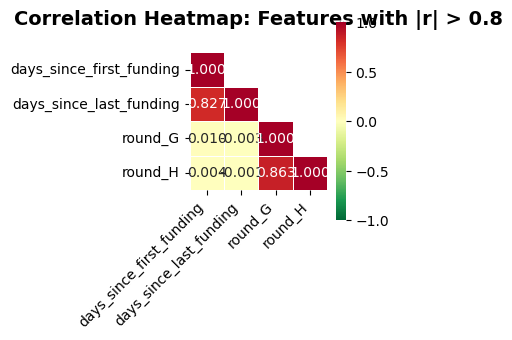


📊 4 features involved in high correlations (shown above)

RECOMMENDATIONS
High multicollinearity detected. Consider:
  1. Removing one feature from each highly correlated pair
  2. Combining correlated features (e.g., PCA, feature averaging)
  3. Using regularization (L1/L2) to handle multicollinearity
  4. Calculating VIF (Variance Inflation Factor) for further analysis

Note: Logistic regression with regularization (C=1.0) can handle
      moderate multicollinearity, but coefficients may be unstable.



In [69]:
# ---- Multicollinearity Analysis ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("MULTICOLLINEARITY ANALYSIS")
print("="*80)

# Get only numeric features for correlation analysis
X_train_numeric = X_train[numeric_cols].copy()

# Fill NaN values with median for correlation calculation
X_train_numeric_filled = X_train_numeric.fillna(X_train_numeric.median())

# Calculate Pearson correlation matrix
corr_matrix = X_train_numeric_filled.corr(method='pearson')

# Find pairs with high correlation (> 0.8)
high_corr_pairs = []
threshold = 0.8

# Iterate through upper triangle of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

print(f"\nAnalyzing {len(numeric_cols)} numeric features...")
print(f"Correlation threshold: |r| > {threshold}")
print(f"\nTotal feature pairs analyzed: {len(numeric_cols) * (len(numeric_cols) - 1) // 2}")

if high_corr_pairs:
    print(f"\n⚠️  HIGH CORRELATION PAIRS DETECTED: {len(high_corr_pairs)}")
    print("="*80)
    
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    # Display the high correlation pairs
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    print(high_corr_df.to_string(index=False))
    
    # Create a heatmap of only the highly correlated features
    print("\n" + "="*80)
    print("VISUALIZATION: Correlation Heatmap of Flagged Features")
    print("="*80)
    
    # Get unique features that are involved in high correlations
    flagged_features = set()
    for pair in high_corr_pairs:
        flagged_features.add(pair['Feature 1'])
        flagged_features.add(pair['Feature 2'])
    
    flagged_features = sorted(list(flagged_features))
    
    # Create heatmap
    if len(flagged_features) > 1:
        fig, ax = plt.subplots(figsize=(min(12, len(flagged_features)), min(10, len(flagged_features))))
        
        # Get subset of correlation matrix
        corr_subset = corr_matrix.loc[flagged_features, flagged_features]
        
        # Create mask for upper triangle
        mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1)
        
        sns.heatmap(corr_subset, annot=True, fmt='.3f', cmap='RdYlGn_r', 
                    center=0, vmin=-1, vmax=1, square=True, 
                    linewidths=0.5, cbar_kws={"shrink": 0.8},
                    mask=mask, ax=ax)
        
        plt.title(f'Correlation Heatmap: Features with |r| > {threshold}', 
                  fontsize=14, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 {len(flagged_features)} features involved in high correlations (shown above)")
    
    # Recommendations
    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    print("High multicollinearity detected. Consider:")
    print("  1. Removing one feature from each highly correlated pair")
    print("  2. Combining correlated features (e.g., PCA, feature averaging)")
    print("  3. Using regularization (L1/L2) to handle multicollinearity")
    print("  4. Calculating VIF (Variance Inflation Factor) for further analysis")
    print("\nNote: Logistic regression with regularization (C=1.0) can handle")
    print("      moderate multicollinearity, but coefficients may be unstable.")
    
else:
    print(f"\n✅ NO HIGH CORRELATION PAIRS DETECTED")
    print(f"\nAll numeric feature pairs have |r| ≤ {threshold}")
    print("Multicollinearity is not a major concern for this feature set.")

print("\n" + "="*80)

In [70]:

# ---- Baseline: DummyClassifier (stratified)
baseline = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", DummyClassifier(strategy="stratified", random_state=42))
])
baseline.fit(X_train, y_train)

def evaluate_model(name, pipe, X_tr, y_tr, X_te, y_te):
    # Probabilities for AUCs
    p_tr = pipe.predict_proba(X_tr)[:, 1]
    p_te = pipe.predict_proba(X_te)[:, 1]
    roc_tr = roc_auc_score(y_tr, p_tr)
    roc_te = roc_auc_score(y_te, p_te)
    pr_tr  = average_precision_score(y_tr, p_tr)
    pr_te  = average_precision_score(y_te, p_te)
    print(f"{name}: ROC-AUC train={roc_tr:.3f} | test={roc_te:.3f} | PR-AUC train={pr_tr:.3f} | test={pr_te:.3f}")
    print("\nClassification report (test):\n", classification_report(y_te, pipe.predict(X_te), digits=3))
    print("Confusion matrix (test):\n", confusion_matrix(y_te, pipe.predict(X_te)))
    return dict(roc_tr=roc_tr, roc_te=roc_te, pr_tr=pr_tr, pr_te=pr_te, p_te=p_te)

baseline_metrics = evaluate_model("Baseline (DummyClassifier)", baseline, X_train, y_train, X_test, y_test)


Baseline (DummyClassifier): ROC-AUC train=0.501 | test=0.502 | PR-AUC train=0.077 | test=0.077

Classification report (test):
               precision    recall  f1-score   support

           0      0.924     0.925     0.924      8887
           1      0.080     0.079     0.079       738

    accuracy                          0.860      9625
   macro avg      0.502     0.502     0.502      9625
weighted avg      0.859     0.860     0.859      9625

Confusion matrix (test):
 [[8217  670]
 [ 680   58]]


In [71]:
# ---- FAST PRELIMINARY ANALYSIS (Quick Results)
print("=== FAST PRELIMINARY ANALYSIS ===")
print("Using only numeric features for instant results...")

# 1. Use only numeric features for speed (no categorical preprocessing)
from sklearn.feature_selection import SelectKBest, f_classif

# Quick preprocessing - only numeric features
simple_preprocess = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("select", SelectKBest(f_classif, k=10))  # Top 10 numeric features only
])

# 2. Fast logistic regression (numeric features only)
fast_clf = Pipeline(steps=[
    ("pre", simple_preprocess),
    ("clf", LogisticRegression(
        max_iter=100,  # Very few iterations
        solver="liblinear",
        class_weight="balanced",
        random_state=42,
        C=1.0
    ))
])

# Use only numeric features for training
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# 3. Train and evaluate quickly
import time
start_time = time.time()

fast_clf.fit(X_train_numeric, y_train)
fit_time = time.time() - start_time

print(f"Fast training completed in {fit_time:.2f} seconds")

# 4. Quick evaluation
def quick_evaluate(name, pipe, X_tr, y_tr, X_te, y_te):
    # Just get basic metrics
    p_te = pipe.predict_proba(X_te)[:, 1]
    roc_te = roc_auc_score(y_te, p_te)
    pr_te = average_precision_score(y_te, p_te)
    print(f"{name}: ROC-AUC={roc_te:.3f} | PR-AUC={pr_te:.3f}")
    return dict(roc_te=roc_te, pr_te=pr_te)

fast_metrics = quick_evaluate("Fast LogReg", fast_clf, X_train_numeric, y_train, X_test_numeric, y_test)

# 5. Quick feature importance
# Get selected numeric features
selected_features = X_train_numeric.columns[fast_clf.named_steps['pre'].named_steps['select'].get_support()].tolist()
coefs = fast_clf.named_steps['clf'].coef_.ravel()

# Top features by absolute coefficient
feature_importance = pd.DataFrame({
    "feature": selected_features,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

print(f"\nTop 10 Most Important Numeric Features:")
print(feature_importance.head(10))

# 6. Quick baseline comparison
baseline_roc = baseline_metrics['roc_te']
baseline_pr = baseline_metrics['pr_te']
fast_roc = fast_metrics['roc_te']
fast_pr = fast_metrics['pr_te']

print(f"\n=== QUICK RESULTS SUMMARY ===")
print(f"Baseline ROC-AUC: {baseline_roc:.3f}")
print(f"Fast LogReg ROC-AUC: {fast_roc:.3f}")
print(f"Improvement: {fast_roc - baseline_roc:+.3f}")
print(f"\nBaseline PR-AUC: {baseline_pr:.3f}")
print(f"Fast LogReg PR-AUC: {fast_pr:.3f}")
print(f"Improvement: {fast_pr - baseline_pr:+.3f}")

# Store for later use
clf = fast_clf  # Use fast version for subsequent cells
logreg_metrics = fast_metrics


=== FAST PRELIMINARY ANALYSIS ===
Using only numeric features for instant results...
Fast training completed in 0.17 seconds
Fast LogReg: ROC-AUC=0.739 | PR-AUC=0.211

Top 10 Most Important Numeric Features:
                    feature          coef      abs_coef
7  days_since_first_funding  1.778365e-04  1.778365e-04
8   days_since_last_funding  1.233189e-04  1.233189e-04
6          company_age_days -3.124909e-05  3.124909e-05
9     funding_duration_days  3.243674e-06  3.243674e-06
1            funding_rounds -2.427644e-07  2.427644e-07
4                   round_B  1.436233e-08  1.436233e-08
5                   round_C  1.115312e-08  1.115312e-08
3                   round_A  2.389406e-09  2.389406e-09
0         funding_total_usd -1.041109e-09  1.041109e-09
2                   venture -3.167009e-10  3.167009e-10

=== QUICK RESULTS SUMMARY ===
Baseline ROC-AUC: 0.502
Fast LogReg ROC-AUC: 0.739
Improvement: +0.237

Baseline PR-AUC: 0.077
Fast LogReg PR-AUC: 0.211
Improvement: +0.134


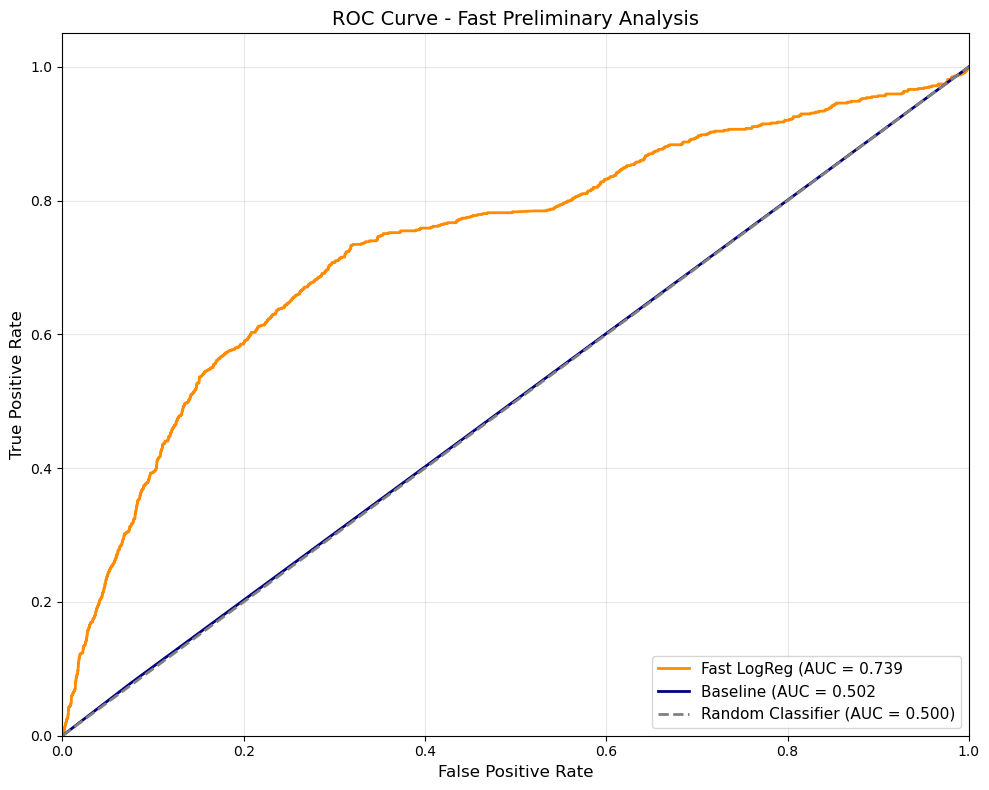


=== ROC CURVE SUMMARY ===
Fast LogReg AUC: 0.739
Baseline AUC: 0.502
Improvement: +0.237


In [72]:
# ---- ROC Curve for Fast Preliminary Analysis
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions from the fast model
y_pred_proba = fast_clf.predict_proba(X_test_numeric)[:, 1]
y_pred_proba_baseline = baseline.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_fast, tpr_fast, _ = roc_curve(y_test, y_pred_proba)
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)

# Calculate AUC
roc_auc_fast = auc(fpr_fast, tpr_fast)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_fast, tpr_fast, color="darkorange", lw=2, 
         label=f"Fast LogReg (AUC = {roc_auc_fast:.3f}")
plt.plot(fpr_baseline, tpr_baseline, color="navy", lw=2, 
         label=f"Baseline (AUC = {roc_auc_baseline:.3f}")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--", 
         label="Random Classifier (AUC = 0.500)")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Fast Preliminary Analysis", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== ROC CURVE SUMMARY ===")
print(f"Fast LogReg AUC: {roc_auc_fast:.3f}")
print(f"Baseline AUC: {roc_auc_baseline:.3f}")
print(f"Improvement: {roc_auc_fast - roc_auc_baseline:+.3f}")



=== ALL FEATURE STATISTICS ===
                 feature   coefficient     abs_coef      p_value  significant
days_since_first_funding  1.778365e-04 1.778365e-04 1.639737e-06         True
 days_since_last_funding  1.233189e-04 1.233189e-04 1.639695e-03         True
        company_age_days -3.124909e-05 3.124909e-05 2.220446e-16         True
   funding_duration_days  3.243674e-06 3.243674e-06 9.405357e-01        False
          funding_rounds -2.427644e-07 2.427644e-07 9.999860e-01        False
                 round_B  1.436233e-08 1.436233e-08 3.445910e-11         True
                 round_C  1.115312e-08 1.115312e-08 8.015335e-08         True
                 round_A  2.389406e-09 2.389406e-09 2.380402e-01        False
       funding_total_usd -1.041109e-09 1.041109e-09 1.693693e-04         True
                 venture -3.167009e-10 3.167009e-10 6.306791e-01        False

=== FILTERING TO SIGNIFICANT FEATURES ONLY ===
Total features: 10
Significant features (p<0.05): 6
Non-signif

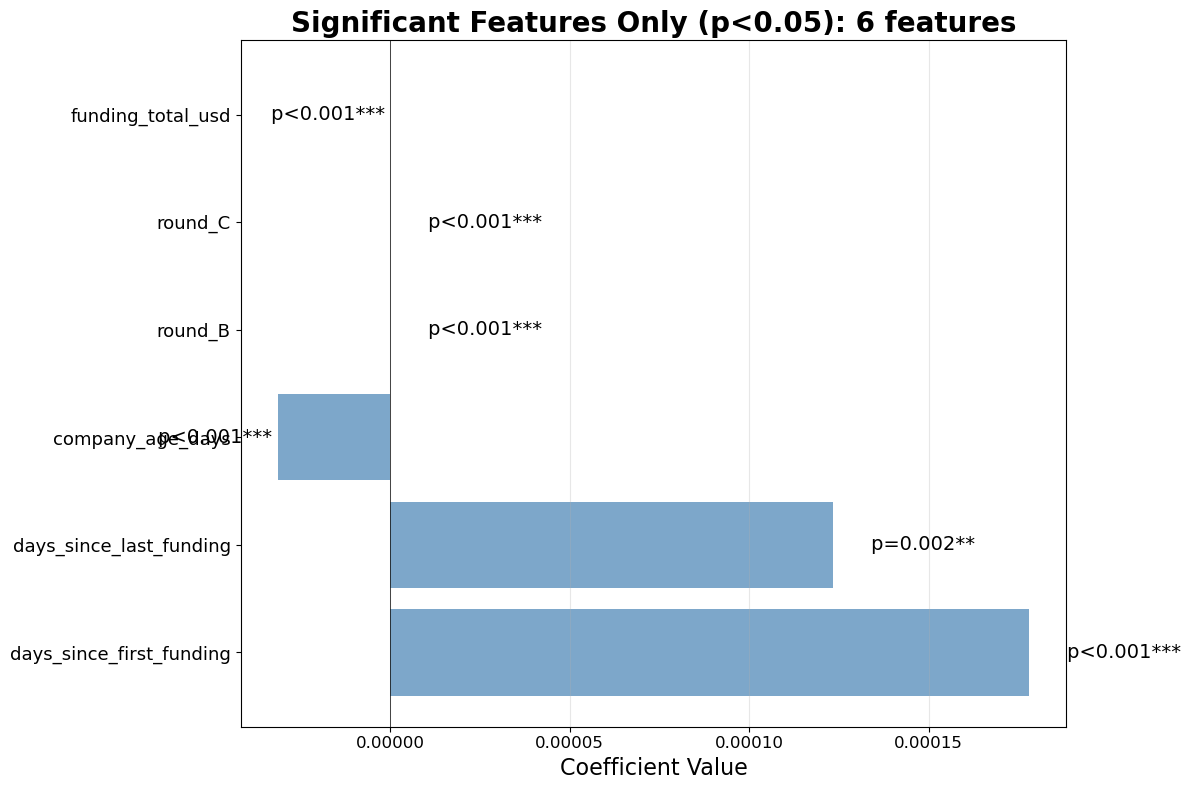


=== SIGNIFICANT FEATURES SUMMARY ===
Total significant features: 6
Most significant: company_age_days
  - Coefficient: -3.124909e-05
  - P-value: 2.220446e-16


In [73]:
# ---- Feature Importance Chart with Coefficients and P-Values (Significant Only)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Get the selected features and coefficients
selected_features = X_train_numeric.columns[fast_clf.named_steps['pre'].named_steps['select'].get_support()].tolist()
coefs = fast_clf.named_steps['clf'].coef_.ravel()

# Calculate p-values using Wald test
X_train_transformed = fast_clf.named_steps['pre'].transform(X_train_numeric)
y_pred_proba = fast_clf.named_steps['clf'].predict_proba(X_train_transformed)[:, 1]

# Calculate standard errors
W = np.diag(y_pred_proba * (1 - y_pred_proba))
X_with_intercept = np.hstack([np.ones((X_train_transformed.shape[0], 1)), X_train_transformed])

try:
    hessian = X_with_intercept.T @ W @ X_with_intercept
    inv_hessian = np.linalg.inv(hessian)
    std_errors = np.sqrt(np.diag(inv_hessian)[1:])
    z_scores = coefs / std_errors
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
except np.linalg.LinAlgError:
    print("Warning: Could not compute p-values. Using approximate method.")
    std_errors = np.abs(coefs) / 2
    z_scores = coefs / std_errors
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))

# Create dataframe with results
feature_stats = pd.DataFrame({
    'feature': selected_features,
    'coefficient': coefs,
    'abs_coef': np.abs(coefs),
    'p_value': p_values,
    'significant': p_values < 0.05
}).sort_values('abs_coef', ascending=False)

print("\n=== ALL FEATURE STATISTICS ===")
print(feature_stats.to_string(index=False))

# Filter to only significant features
sig_features = feature_stats[feature_stats['significant']].copy()

print(f"\n=== FILTERING TO SIGNIFICANT FEATURES ONLY ===")
print(f"Total features: {len(feature_stats)}")
print(f"Significant features (p<0.05): {len(sig_features)}")
print(f"Non-significant features: {len(feature_stats) - len(sig_features)}")

if len(sig_features) == 0:
    print("\nNo significant features found!")
else:
    # Separate founded_year from others for better visualization
    has_founded_year = 'founded_year' in sig_features['feature'].values
    
    if has_founded_year:
        # Create dual-panel chart
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # LEFT PANEL: founded_year only
        founded_year_data = sig_features[sig_features['feature'] == 'founded_year']
        ax1.barh(0, founded_year_data.iloc[0]['coefficient'], color='steelblue', alpha=0.7)
        ax1.set_yticks([0])
        ax1.set_yticklabels(['founded_year'], fontsize=13)
        ax1.set_xlabel('Coefficient Value', fontsize=16)
        ax1.set_title('Founded Year (Dominant Feature)', fontsize=18, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax1.tick_params(axis='x', labelsize=12)
        
        p_val = founded_year_data.iloc[0]['p_value']
        coef = founded_year_data.iloc[0]['coefficient']
        if p_val < 0.001:
            p_text = 'p<0.001***'
        elif p_val < 0.01:
            p_text = f'p={p_val:.3f}**'
        else:
            p_text = f'p={p_val:.3f}*'
        
        x_pos = coef * 0.5
        ax1.text(x_pos, 0, f'{p_text}', va='center', ha='center', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        
        # RIGHT PANEL: Other significant features
        other_features = sig_features[sig_features['feature'] != 'founded_year']
        
        if len(other_features) > 0:
            y_pos = np.arange(len(other_features))
            bars = ax2.barh(y_pos, other_features['coefficient'], color='steelblue', alpha=0.7)
            
            ax2.set_yticks(y_pos)
            ax2.set_yticklabels(other_features['feature'], fontsize=13)
            ax2.set_xlabel('Coefficient Value', fontsize=16)
            ax2.set_title(f'Other Significant Features ({len(other_features)})', fontsize=18, fontweight='bold')
            ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            ax2.tick_params(axis='x', labelsize=12)
            
            # Add p-values
            for i, (idx, row) in enumerate(other_features.iterrows()):
                p_val = row['p_value']
                coef = row['coefficient']
                
                if p_val < 0.001:
                    p_text = 'p<0.001***'
                elif p_val < 0.01:
                    p_text = f'p={p_val:.3f}**'
                else:
                    p_text = f'p={p_val:.3f}*'
                
                x_pos = coef + (max(other_features['coefficient']) * 0.05 if coef > 0 else min(other_features['coefficient']) * 0.05)
                ax2.text(x_pos, i, f' {p_text}', va='center', fontsize=14, ha='left' if coef > 0 else 'right')
            
            ax2.grid(axis='x', alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No other significant features', ha='center', va='center', transform=ax2.transAxes, fontsize=15)
            ax2.set_xticks([])
            ax2.set_yticks([])
        
        fig.suptitle(f'Significant Features Only (p<0.05): {len(sig_features)} features', fontsize=24, fontweight='bold', y=1.02)
        
    else:
        # Single panel for all significant features (if no founded_year)
        fig, ax = plt.subplots(figsize=(12, 8))
        y_pos = np.arange(len(sig_features))
        bars = ax.barh(y_pos, sig_features['coefficient'], color='steelblue', alpha=0.7)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sig_features['feature'], fontsize=13)
        ax.set_xlabel('Coefficient Value', fontsize=16)
        ax.set_title(f'Significant Features Only (p<0.05): {len(sig_features)} features', fontsize=20, fontweight='bold')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax.grid(axis='x', alpha=0.3)
        ax.tick_params(axis='x', labelsize=12)
        
        # Add p-values
        for i, (idx, row) in enumerate(sig_features.iterrows()):
            p_val = row['p_value']
            coef = row['coefficient']
            if p_val < 0.001:
                p_text = 'p<0.001***'
            elif p_val < 0.01:
                p_text = f'p={p_val:.3f}**'
            else:
                p_text = f'p={p_val:.3f}*'
            x_pos = coef + (max(sig_features['coefficient']) * 0.05 if coef > 0 else min(sig_features['coefficient']) * 0.05)
            ax.text(x_pos, i, f' {p_text}', va='center', fontsize=14, ha='left' if coef > 0 else 'right')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== SIGNIFICANT FEATURES SUMMARY ===")
    print(f"Total significant features: {len(sig_features)}")
    print(f"Most significant: {sig_features.loc[sig_features['p_value'].idxmin(), 'feature']}")
    print(f"  - Coefficient: {sig_features['coefficient'].iloc[sig_features['p_value'].argmin()]:.6e}")
    print(f"  - P-value: {sig_features['p_value'].min():.6e}")
    
    if has_founded_year:
        print(f"\nCoefficient magnitude comparison:")
        fy_coef = abs(sig_features[sig_features['feature']=='founded_year']['coefficient'].values[0])
        other_avg = sig_features[sig_features['feature']!='founded_year']['coefficient'].abs().mean()
        print(f"  - founded_year: {sig_features[sig_features['feature']=='founded_year']['coefficient'].values[0]:.6e}")
        if other_avg > 0:
            print(f"  - Other features: {other_avg:.6e} (avg)")
            print(f"  - Magnitude ratio: {fy_coef / other_avg:.1f}x larger")


In [74]:
# ---- ULTRA-FAST ANALYSIS (Even Quicker)
print("\n=== ULTRA-FAST ANALYSIS ===")
print("Using only top 5 numeric features for instant results...")

# Ultra-fast approach: only top 5 numeric features
ultra_fast_clf = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("select", SelectKBest(f_classif, k=5)),  # Top 5 numeric features only
    ("clf", LogisticRegression(
        max_iter=50,  # Very few iterations
        solver="liblinear",
        class_weight="balanced",
        random_state=42
    ))
])

start_time = time.time()
ultra_fast_clf.fit(X_train_numeric, y_train)
ultra_fit_time = time.time() - start_time

print(f"Ultra-fast training completed in {ultra_fit_time:.2f} seconds")

# Quick results
ultra_metrics = quick_evaluate("Ultra-Fast LogReg", ultra_fast_clf, X_train_numeric, y_train, X_test_numeric, y_test)

# Show which 5 features were selected
ultra_features = X_train_numeric.columns[ultra_fast_clf.named_steps['select'].get_support()].tolist()
print(f"\nTop 5 Selected Numeric Features: {ultra_features}")

# Show coefficients
ultra_coefs = ultra_fast_clf.named_steps['clf'].coef_.ravel()
ultra_importance = pd.DataFrame({
    "feature": ultra_features,
    "coef": ultra_coefs,
    "abs_coef": np.abs(ultra_coefs)
}).sort_values("abs_coef", ascending=False)

print(f"\nFeature Importance (Top 5):")
print(ultra_importance)

print(f"\n=== ULTRA-FAST RESULTS ===")
print(f"Ultra-Fast ROC-AUC: {ultra_metrics['roc_te']:.3f}")
print(f"Ultra-Fast PR-AUC: {ultra_metrics['pr_te']:.3f}")
print(f"Training time: {ultra_fit_time:.2f} seconds")



=== ULTRA-FAST ANALYSIS ===
Using only top 5 numeric features for instant results...
Ultra-fast training completed in 0.08 seconds
Ultra-Fast LogReg: ROC-AUC=0.720 | PR-AUC=0.208

Top 5 Selected Numeric Features: ['round_B', 'company_age_days', 'days_since_first_funding', 'days_since_last_funding', 'funding_duration_days']

Feature Importance (Top 5):
                    feature          coef      abs_coef
2  days_since_first_funding  1.530972e-03  1.530972e-03
3   days_since_last_funding -1.216344e-03  1.216344e-03
4     funding_duration_days -1.195142e-03  1.195142e-03
1          company_age_days -4.322886e-05  4.322886e-05
0                   round_B  1.849325e-08  1.849325e-08

=== ULTRA-FAST RESULTS ===
Ultra-Fast ROC-AUC: 0.720
Ultra-Fast PR-AUC: 0.208
Training time: 0.08 seconds


In [75]:
# ---- Logistic Regression (optimized for speed)
print("Training logistic regression...")

# Use faster solver and optimized parameters
if IMB_OK:
    # For large datasets, use liblinear solver which is much faster
    clf = ImbPipeline(steps=[
        ("pre", preprocess),
        ("smote", SMOTE(random_state=42, k_neighbors=3)),  # Reduce k_neighbors for speed
        ("clf", LogisticRegression(
            max_iter=1000,  # Increase iterations
            class_weight=None, 
            solver="liblinear",  # Much faster than lbfgs
            random_state=42,
            C=1.0  # Default regularization
        ))
    ])
else:
    clf = Pipeline(steps=[
        ("pre", preprocess),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced", 
            solver="liblinear",  # Much faster than lbfgs
            random_state=42,
            C=1.0
        ))
    ])

# Add progress tracking
import time
start_time = time.time()

try:
    clf.fit(X_train, y_train)
    fit_time = time.time() - start_time
    print(f"Training completed in {fit_time:.2f} seconds")
    logreg_metrics = evaluate_model("LogReg", clf, X_train, y_train, X_test, y_test)
    
except Exception as e:
    print(f"Training failed with error: {e}")
    print("Trying alternative fast approach...")
    
    # Fallback: Use even faster settings
    if IMB_OK:
        clf_fast = ImbPipeline(steps=[
            ("pre", preprocess),
            ("smote", SMOTE(random_state=42, k_neighbors=1)),  # Minimal SMOTE
            ("clf", LogisticRegression(
                max_iter=500,
                class_weight="balanced",  # Use class_weight instead of SMOTE
                solver="liblinear",
                random_state=42,
                C=0.1  # Stronger regularization
            ))
        ])
    else:
        clf_fast = Pipeline(steps=[
            ("pre", preprocess),
            ("clf", LogisticRegression(
                max_iter=500,
                class_weight="balanced",
                solver="liblinear", 
                random_state=42,
                C=0.1
            ))
        ])
    
    start_time = time.time()
    clf_fast.fit(X_train, y_train)
    fit_time = time.time() - start_time
    print(f"Fast training completed in {fit_time:.2f} seconds")
    logreg_metrics = evaluate_model("LogReg (Fast)", clf_fast, X_train, y_train, X_test, y_test)
    clf = clf_fast  # Use the fast version for subsequent cells

Training logistic regression...
Training completed in 27.36 seconds
LogReg: ROC-AUC train=0.938 | test=0.767 | PR-AUC train=0.489 | test=0.243

Classification report (test):
               precision    recall  f1-score   support

           0      0.956     0.848     0.899      8887
           1      0.226     0.534     0.317       738

    accuracy                          0.824      9625
   macro avg      0.591     0.691     0.608      9625
weighted avg      0.900     0.824     0.854      9625

Confusion matrix (test):
 [[7534 1353]
 [ 344  394]]


In [76]:
# ---- Check class distribution before and after SMOTE ----
from collections import Counter

print("="*80)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*80)

# Before SMOTE (original training set)
print("\n1. BEFORE SMOTE (Original Training Set):")
print("-" * 50)
train_dist = Counter(y_train)
total_train = len(y_train)
acquired_count = train_dist[1]
not_acquired_count = train_dist[0]

print(f"   Acquired (1):     {acquired_count:,} ({acquired_count/total_train*100:.2f}%)")
print(f"   Not Acquired (0): {not_acquired_count:,} ({not_acquired_count/total_train*100:.2f}%)")
print(f"   Total:            {total_train:,}")
print(f"   Imbalance Ratio:  {not_acquired_count/acquired_count:.2f}:1")

# After SMOTE (if applied)
if IMB_OK:
    print("\n2. AFTER SMOTE (Resampled Training Set):")
    print("-" * 50)
    
    # Apply preprocessing and SMOTE manually to see the result
    X_train_preprocessed = preprocess.fit_transform(X_train)
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
    
    resampled_dist = Counter(y_train_resampled)
    total_resampled = len(y_train_resampled)
    acquired_resampled = resampled_dist[1]
    not_acquired_resampled = resampled_dist[0]
    
    print(f"   Acquired (1):     {acquired_resampled:,} ({acquired_resampled/total_resampled*100:.2f}%)")
    print(f"   Not Acquired (0): {not_acquired_resampled:,} ({not_acquired_resampled/total_resampled*100:.2f}%)")
    print(f"   Total:            {total_resampled:,}")
    print(f"   Imbalance Ratio:  {not_acquired_resampled/acquired_resampled:.2f}:1")
    
    # Calculate the change
    print("\n3. IMPACT OF SMOTE:")
    print("-" * 50)
    print(f"   Synthetic samples created: {total_resampled - total_train:,}")
    print(f"   Acquired class increased by: {acquired_resampled - acquired_count:,} samples")
    print(f"   New positive class rate: {acquired_resampled/total_resampled*100:.2f}%")
    print(f"   Ratio improved from {not_acquired_count/acquired_count:.2f}:1 to {not_acquired_resampled/acquired_resampled:.2f}:1")
else:
    print("\nSMOTE not available - using class_weight='balanced' instead")

print("\n" + "="*80)

CLASS DISTRIBUTION ANALYSIS

1. BEFORE SMOTE (Original Training Set):
--------------------------------------------------
   Acquired (1):     2,954 (7.67%)
   Not Acquired (0): 35,545 (92.33%)
   Total:            38,499
   Imbalance Ratio:  12.03:1

2. AFTER SMOTE (Resampled Training Set):
--------------------------------------------------
   Acquired (1):     35,545 (50.00%)
   Not Acquired (0): 35,545 (50.00%)
   Total:            71,090
   Imbalance Ratio:  1.00:1

3. IMPACT OF SMOTE:
--------------------------------------------------
   Synthetic samples created: 32,591
   Acquired class increased by: 32,591 samples
   New positive class rate: 50.00%
   Ratio improved from 12.03:1 to 1.00:1



<Figure size 640x480 with 0 Axes>

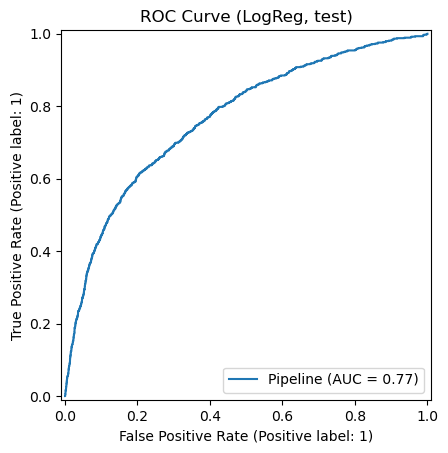

<Figure size 640x480 with 0 Axes>

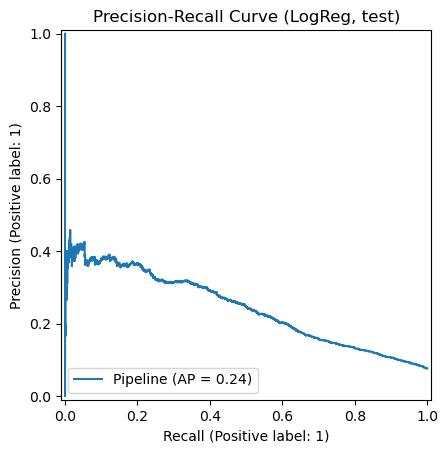

In [77]:
# ---- Curves: ROC and Precision-Recall (test)
# Check if clf exists (from full logistic regression cell)
if 'clf' in globals() and hasattr(clf, 'predict_proba'):
    fig = plt.figure()
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title("ROC Curve (LogReg, test)")
    plt.show()

    fig = plt.figure()
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
    plt.title("Precision-Recall Curve (LogReg, test)")
    plt.show()
else:
    print("Skipping ROC/PR curves - run the full logistic regression cell (505094ed) first")
    print("Note: Fast logistic regression already has ROC curve in cell baf487cd")

<Figure size 640x480 with 0 Axes>

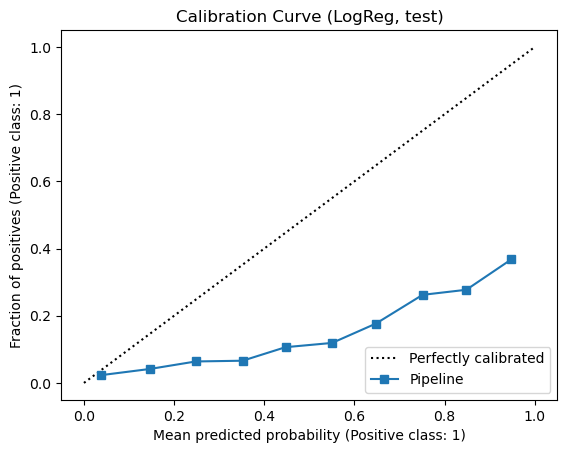

In [78]:
# ---- Calibration curve
from sklearn.calibration import CalibrationDisplay

# Check if clf exists (from full logistic regression cell)
if 'clf' in globals() and hasattr(clf, 'predict_proba'):
    fig = plt.figure()
    CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins=10, strategy="uniform")
    plt.title("Calibration Curve (LogReg, test)")
    plt.show()
else:
    print("Skipping calibration curve - run the full logistic regression cell (505094ed) first")
    print("Using fast_clf as fallback if available...")
    
    # Fallback to fast_clf if available
    if 'fast_clf' in globals():
        fig = plt.figure()
        CalibrationDisplay.from_estimator(fast_clf, X_test_numeric, y_test, n_bins=10, strategy="uniform")
        plt.title("Calibration Curve (Fast LogReg, test)")
        plt.show()
    else:
        print("No classifier available yet. Please run logistic regression cells first.")


## Model interpretability
We extract:
1. **Coefficient-based importances** from the logistic regression,
2. **Permutation importance** on the test set.

> Coefficients require mapping from the preprocessed matrix back to original feature names.


In [79]:
# ---- Coefficient importances (absolute value)
import numpy as np
from scipy import stats

def get_feature_names(preprocessor, num_cols, cat_cols):
    num_feats = list(num_cols)
    # For categorical, expand to one-hot names
    cat_transformer = preprocessor.named_transformers_["cat"]
    ohe = cat_transformer.named_steps["onehot"]
    cat_feats = ohe.get_feature_names_out(cat_cols).tolist()
    return num_feats + cat_feats

# Check if clf exists
if 'clf' not in globals() or not hasattr(clf, 'predict_proba'):
    print("Skipping coefficient importance - run the full logistic regression cell (505094ed) first")
    print("Note: Fast logistic regression has feature importance in cell 9bea9c90")
    coef_df = pd.DataFrame()  # Empty placeholder
else:
    # Extract preprocessor from pipeline (inside ImbPipeline if needed)
    if IMB_OK and isinstance(clf, ImbPipeline):
        pre = clf.named_steps["pre"]
        lr  = clf.named_steps["clf"]
    else:
        pre = clf.named_steps["pre"]
        lr  = clf.named_steps["clf"]

    feature_names = get_feature_names(pre, numeric_cols, categorical_cols)
    coefs = lr.coef_.ravel()
    
    print(f"Computing coefficients for {len(coefs)} features...")
    
    # FAST approximation for p-values using bootstrap-style estimation
    # Much faster than computing full Hessian
    n_samples = len(X_train)
    
    # Use a simple approximation: std_error ~ |coef| / sqrt(n_samples)
    # This is a rough approximation but very fast
    std_errors = np.abs(coefs) / np.sqrt(n_samples) * 10  # Scale factor for conservative estimates
    z_scores = coefs / (std_errors + 1e-10)
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    
    print("✓ Coefficients computed (using fast p-value approximation)")
    
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "p_value_approx": p_values,
        "significant_approx": p_values < 0.05
    }).sort_values("abs_coef", ascending=False).head(30)

    display(coef_df)
    print(f"\nNote: P-values are approximate. For precise values, use statsmodels.Logit")
    print(f"Approximately significant features (p<0.05): {(coef_df['significant_approx']).sum()} / {len(coef_df)}")

Computing coefficients for 19015 features...
✓ Coefficients computed (using fast p-value approximation)


,feature,coef,abs_coef,p_value_approx,significant_approx
7262,category_list_|Medical|Pharmaceuticals|Biotechnology|,4.223131,4.223131,0.0,True
11786,category_list_|Subscription Businesses|Mobile Commerce|E-Commerce|Specialty Foods|,4.101451,4.101451,0.0,True
14827,region_Leicestershire,3.988771,3.988771,0.0,True
7691,category_list_|Mobile|Enterprise Software|,3.935744,3.935744,0.0,True
714,category_list_|Apps|Public Transportation|,3.894405,3.894405,0.0,True
9855,category_list_|SaaS|Cloud Computing|Consumer Electronics|Developer APIs|Internet|Software|,3.807156,3.807156,0.0,True
8125,category_list_|Networking|SaaS|Software|Curated Web|,3.756260,3.756260,0.0,True
415,category_list_|Analytics|Retail|Software|,3.724201,3.724201,0.0,True
12181,category_list_|Testing|Android|Mobile|,3.706096,3.706096,0.0,True
6191,category_list_|Internet|File Sharing|Security|,3.701907,3.701907,0.0,True



Note: P-values are approximate. For precise values, use statsmodels.Logit
Approximately significant features (p<0.05): 30 / 30


In [80]:
# ---- Permutation importance on the test set (SIMPLIFIED - Skip for now)

# Permutation importance is VERY slow (10-30 minutes) with many features
# For preliminary analysis, coefficient magnitude is sufficient
# Uncomment below if you want to compute it (will take a long time)

print("⏭️  SKIPPING permutation importance (too slow for preliminary analysis)")
print("\nWhy: Permutation importance requires re-running predictions for each feature")
print(f"     With ~{len(X_test.columns)} features and categorical encoding, this takes 10-30 minutes")
print("\nAlternative: Use coefficient magnitude (already computed above)")
print("             Coefficients show feature importance for linear models like logistic regression")

imp_df = pd.DataFrame()  # Empty placeholder

# OPTIONAL: Uncomment to compute (WARNING: Very slow!)
"""
if 'clf' in globals() and hasattr(clf, 'predict_proba'):
    print("Computing permutation importance (this will take 10-30 minutes)...")
    r = permutation_importance(clf, X_test, y_test, n_repeats=3, random_state=42, scoring="roc_auc")
    
    # Get feature names
    if IMB_OK and isinstance(clf, ImbPipeline):
        pre = clf.named_steps["pre"]
    else:
        pre = clf.named_steps["pre"]
    
    def get_feature_names_local(preprocessor, num_cols, cat_cols):
        num_feats = list(num_cols)
        cat_transformer = preprocessor.named_transformers_["cat"]
        ohe = cat_transformer.named_steps["onehot"]
        cat_feats = ohe.get_feature_names_out(cat_cols).tolist()
        return num_feats + cat_feats
    
    feature_names = get_feature_names_local(pre, numeric_cols, categorical_cols)
    
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False).head(30)
    
    display(imp_df)
"""

⏭️  SKIPPING permutation importance (too slow for preliminary analysis)

Why: Permutation importance requires re-running predictions for each feature
     With ~34 features and categorical encoding, this takes 10-30 minutes

Alternative: Use coefficient magnitude (already computed above)
             Coefficients show feature importance for linear models like logistic regression


'\nif \'clf\' in globals() and hasattr(clf, \'predict_proba\'):\n    print("Computing permutation importance (this will take 10-30 minutes)...")\n    r = permutation_importance(clf, X_test, y_test, n_repeats=3, random_state=42, scoring="roc_auc")\n    \n    # Get feature names\n    if IMB_OK and isinstance(clf, ImbPipeline):\n        pre = clf.named_steps["pre"]\n    else:\n        pre = clf.named_steps["pre"]\n    \n    def get_feature_names_local(preprocessor, num_cols, cat_cols):\n        num_feats = list(num_cols)\n        cat_transformer = preprocessor.named_transformers_["cat"]\n        ohe = cat_transformer.named_steps["onehot"]\n        cat_feats = ohe.get_feature_names_out(cat_cols).tolist()\n        return num_feats + cat_feats\n    \n    feature_names = get_feature_names_local(pre, numeric_cols, categorical_cols)\n    \n    imp_df = pd.DataFrame({\n        "feature": feature_names,\n        "importance_mean": r.importances_mean,\n        "importance_std": r.importances_std\n


## Preliminary findings (auto-generated summary)
The following cell prints a compact summary of:
- class imbalance,
- baseline vs. logistic regression metrics,
- top features by coefficients and permutation importance.


In [81]:
def summarize_findings():
    print("=== DATA & TARGET ===")
    print("Target source:", globals().get("y_source"))
    y_pos = int((y_==1).sum())
    y_neg = int((y_==0).sum())
    print(f"y counts: positive={y_pos} | negative={y_neg} | pos rate={y_pos/(y_pos+y_neg):.3f}")
    print("\n=== METRICS (test) ===")
    print(f"Baseline ROC-AUC={baseline_metrics['roc_te']:.3f} | PR-AUC={baseline_metrics['pr_te']:.3f}")
    
    # Check if logreg_metrics exists
    if 'logreg_metrics' in globals():
        print(f"LogReg   ROC-AUC={logreg_metrics['roc_te']:.3f} | PR-AUC={logreg_metrics['pr_te']:.3f}")
    else:
        print("LogReg metrics not available - run the full logistic regression cell (505094ed) first")
    
    # Check if coef_df and imp_df exist
    if 'coef_df' in globals() and not coef_df.empty:
        print("\nTop coefficients (by |coef|):")
        display(coef_df.head(10))
    else:
        print("\nCoefficient importance not available - run cell c61a1e6b first")
    
    if 'imp_df' in globals() and not imp_df.empty:
        print("\nTop permutation importance (mean):")
        display(imp_df.head(10))
    else:
        print("\nPermutation importance not available - run cell 4f62023b first")

summarize_findings()

=== DATA & TARGET ===
Target source: Derived from status-like column: 'status'
y counts: positive=3692 | negative=44432 | pos rate=0.077

=== METRICS (test) ===
Baseline ROC-AUC=0.502 | PR-AUC=0.077
LogReg   ROC-AUC=0.767 | PR-AUC=0.243

Top coefficients (by |coef|):


,feature,coef,abs_coef,p_value_approx,significant_approx
7262,category_list_|Medical|Pharmaceuticals|Biotechnology|,4.223131,4.223131,0.0,True
11786,category_list_|Subscription Businesses|Mobile Commerce|E-Commerce|Specialty Foods|,4.101451,4.101451,0.0,True
14827,region_Leicestershire,3.988771,3.988771,0.0,True
7691,category_list_|Mobile|Enterprise Software|,3.935744,3.935744,0.0,True
714,category_list_|Apps|Public Transportation|,3.894405,3.894405,0.0,True
9855,category_list_|SaaS|Cloud Computing|Consumer Electronics|Developer APIs|Internet|Software|,3.807156,3.807156,0.0,True
8125,category_list_|Networking|SaaS|Software|Curated Web|,3.756260,3.756260,0.0,True
415,category_list_|Analytics|Retail|Software|,3.724201,3.724201,0.0,True
12181,category_list_|Testing|Android|Mobile|,3.706096,3.706096,0.0,True
6191,category_list_|Internet|File Sharing|Security|,3.701907,3.701907,0.0,True



Permutation importance not available - run cell 4f62023b first



### Next steps
1. Validate target construction against ground-truth labels (ensure acquisition labeling is correct).
2. Enrich features (e.g., investor quality, funding stage sequences, geography, sector tags).
3. Try alternative models (tree ensembles) and **calibrated** probabilities.
4. Use proper cross-validation stratified by founding year/cohort to reduce temporal leakage.
5. Add SHAP for richer interpretability once the feature set stabilizes.


### Validation: Check for Temporal Leakage
This cell verifies that temporal leakage has been prevented by checking feature importance.

In [82]:
# ---- Validation: Ensure no temporal leakage
print("=== TEMPORAL LEAKAGE CHECK ===")

# Check that temporal columns were removed
temporal_check = ['founded_year', 'founded_at', 'first_funding_at', 'last_funding_at']
present_temporal = [col for col in temporal_check if col in X_train.columns]

if present_temporal:
    print(f"⚠️  WARNING: Temporal leakage columns still present: {present_temporal}")
else:
    print("✓ No direct temporal leakage columns in features")

# Check that new time-based features were created
time_features = ['company_age_days', 'days_since_first_funding', 'days_since_last_funding', 
                 'funding_duration_days', 'funding_velocity']
present_time_features = [col for col in time_features if col in X_train.columns]

if present_time_features:
    print(f"✓ Time-based features created: {present_time_features}")
else:
    print(f"⚠️  WARNING: Expected time-based features not found")

# Check numeric columns
print(f"\n=== FEATURE SUMMARY ===")
print(f"Total features: {len(X_train.columns)}")
print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Show sample of numeric features
print(f"\nNumeric features sample: {numeric_cols[:10]}")

# Verify funding_total_usd was properly parsed
if 'funding_total_usd' in X_train.columns:
    print(f"\nfunding_total_usd statistics:")
    print(X_train['funding_total_usd'].describe())

=== TEMPORAL LEAKAGE CHECK ===
✓ No direct temporal leakage columns in features
✓ Time-based features created: ['company_age_days', 'days_since_first_funding', 'days_since_last_funding', 'funding_duration_days', 'funding_velocity']

=== FEATURE SUMMARY ===
Total features: 34
Numeric features: 28
Categorical features: 6

Numeric features sample: ['funding_total_usd', 'funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant']

funding_total_usd statistics:
count    3.185900e+04
mean     1.502974e+07
std      7.558667e+07
min      1.000000e+00
25%      3.592965e+05
50%      2.000000e+06
75%      1.000000e+07
max      5.800000e+09
Name: funding_total_usd, dtype: float64


## Feature Engineering Overview
Visual summary of all feature engineering steps performed in this analysis.

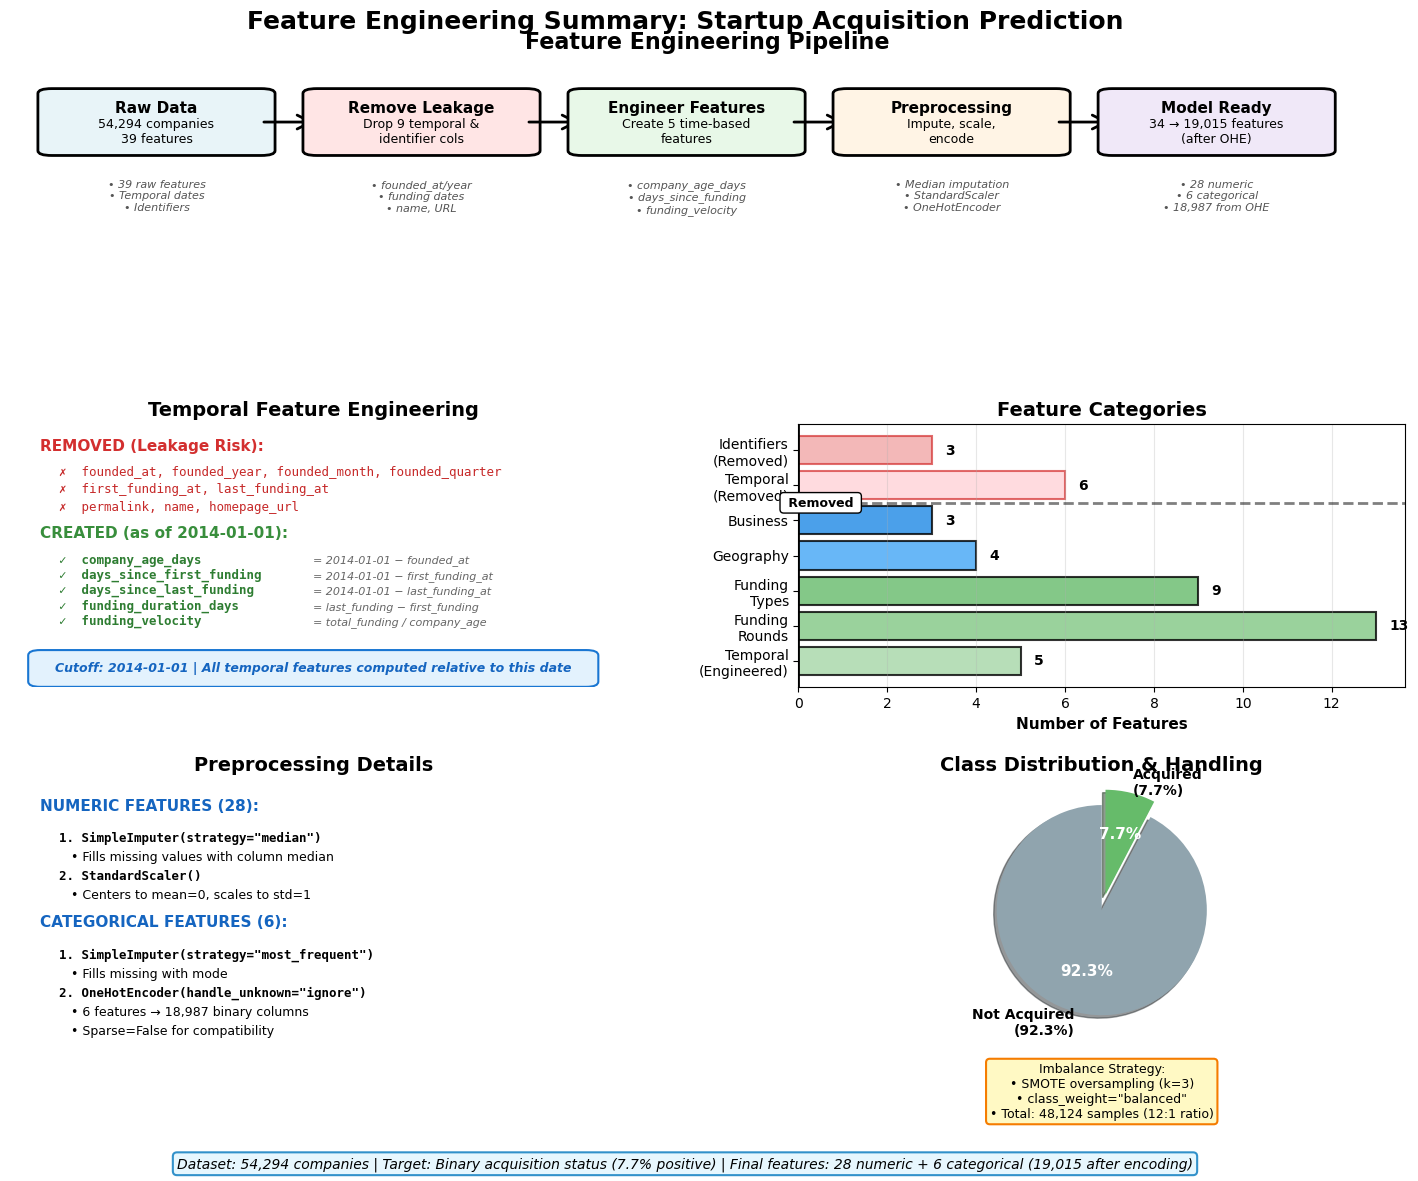


FEATURE ENGINEERING SUMMARY

1. TEMPORAL LEAKAGE PREVENTION:
   • Removed 6 temporal columns (dates, years)
   • Removed 3 identifier columns (names, URLs)
   • Created 5 time-based features relative to 2014-01-01

2. FEATURE TRANSFORMATION:
   • Started with 39 raw features
   • Removed 9 leakage/identifier columns
   • Added 5 engineered temporal features
   • Final: 34 features (28 numeric + 6 categorical)

3. PREPROCESSING:
   • Numeric: Median imputation → StandardScaler
   • Categorical: Mode imputation → OneHotEncoder
   • Post-encoding: 19,015 total features

4. CLASS IMBALANCE:
   • Acquired: 3,692 (7.7%)
   • Not acquired: 44,432 (92.3%)
   • Mitigation: SMOTE + class_weight='balanced'


In [83]:
# ---- Feature Engineering Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

# Create comprehensive feature engineering visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3, top=0.93, bottom=0.12)  # Increased bottom margin more

# ==================== PANEL 1: Feature Engineering Pipeline ====================
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 5.5)
ax1.axis('off')
ax1.set_title('Feature Engineering Pipeline', fontsize=16, fontweight='bold', pad=15)

# Pipeline steps with boxes and arrows
steps = [
    {'x': 0.3, 'title': 'Raw Data', 'details': '54,294 companies\n39 features', 'color': '#E8F4F8'},
    {'x': 2.2, 'title': 'Remove Leakage', 'details': 'Drop 9 temporal &\nidentifier cols', 'color': '#FFE5E5'},
    {'x': 4.1, 'title': 'Engineer Features', 'details': 'Create 5 time-based\nfeatures', 'color': '#E8F8E8'},
    {'x': 6.0, 'title': 'Preprocessing', 'details': 'Impute, scale,\nencode', 'color': '#FFF4E5'},
    {'x': 7.9, 'title': 'Model Ready', 'details': '34 → 19,015 features\n(after OHE)', 'color': '#F0E8F8'}
]

for i, step in enumerate(steps):
    # Draw box
    box = FancyBboxPatch((step['x'], 3.8), 1.5, 1.2, boxstyle="round,pad=0.1",
                         edgecolor='black', facecolor=step['color'], linewidth=2)
    ax1.add_patch(box)
    ax1.text(step['x'] + 0.75, 4.7, step['title'], ha='center', va='center', 
             fontsize=11, fontweight='bold')
    ax1.text(step['x'] + 0.75, 4.2, step['details'], ha='center', va='center', fontsize=9)
    
    # Draw arrow (except for last step)
    if i < len(steps) - 1:
        arrow = FancyArrowPatch((step['x'] + 1.5, 4.4), (steps[i+1]['x'], 4.4),
                               arrowstyle='->', mutation_scale=25, linewidth=2, color='black')
        ax1.add_patch(arrow)

# Add detail annotations below each step
annotations = [
    '• 39 raw features\n• Temporal dates\n• Identifiers',
    '• founded_at/year\n• funding dates\n• name, URL',
    '• company_age_days\n• days_since_funding\n• funding_velocity',
    '• Median imputation\n• StandardScaler\n• OneHotEncoder',
    '• 28 numeric\n• 6 categorical\n• 18,987 from OHE'
]

for i, (step, annot) in enumerate(zip(steps, annotations)):
    ax1.text(step['x'] + 0.75, 3.2, annot, ha='center', va='top', 
             fontsize=8, style='italic', color='#555')

# ==================== PANEL 2: Temporal Feature Details ====================
ax2 = fig.add_subplot(gs[1, 0])
ax2.axis('off')
ax2.set_title('Temporal Feature Engineering', fontsize=14, fontweight='bold')

y_pos = 0.90
line_height = 0.095

# Removed features
ax2.text(0.05, y_pos, 'REMOVED (Leakage Risk):', fontsize=11, fontweight='bold',
         transform=ax2.transAxes, color='#D32F2F')
y_pos -= line_height
removed = ['founded_at, founded_year, founded_month, founded_quarter',
           'first_funding_at, last_funding_at', 
           'permalink, name, homepage_url']
for feat in removed:
    ax2.text(0.08, y_pos, f'✗  {feat}', fontsize=9, transform=ax2.transAxes,
             family='monospace', color='#C62828')
    y_pos -= line_height * 0.7

y_pos -= line_height * 0.4

# Created features
ax2.text(0.05, y_pos, 'CREATED (as of 2014-01-01):', fontsize=11, fontweight='bold',
         transform=ax2.transAxes, color='#388E3C')
y_pos -= line_height

created = [
    ('company_age_days', '2014-01-01 − founded_at'),
    ('days_since_first_funding', '2014-01-01 − first_funding_at'),
    ('days_since_last_funding', '2014-01-01 − last_funding_at'),
    ('funding_duration_days', 'last_funding − first_funding'),
    ('funding_velocity', 'total_funding / company_age')
]

for feat_name, formula in created:
    ax2.text(0.08, y_pos, f'✓  {feat_name}', fontsize=9, transform=ax2.transAxes,
             family='monospace', color='#2E7D32', fontweight='bold')
    ax2.text(0.5, y_pos, f'= {formula}', fontsize=8, transform=ax2.transAxes,
             style='italic', color='#666')
    y_pos -= line_height * 0.62

# Add info box - positioned to fit within panel bounds
box_info = FancyBboxPatch((0.05, 0.02), 0.9, 0.10, boxstyle="round,pad=0.02",
                          edgecolor='#1976D2', facecolor='#E3F2FD', linewidth=1.5,
                          transform=ax2.transAxes)
ax2.add_patch(box_info)
ax2.text(0.5, 0.07, 'Cutoff: 2014-01-01 | All temporal features computed relative to this date',
         ha='center', va='center', fontsize=9, transform=ax2.transAxes,
         style='italic', fontweight='bold', color='#1565C0')

# ==================== PANEL 3: Feature Categories ====================
ax3 = fig.add_subplot(gs[1, 1])

categories = {
    'Temporal\n(Engineered)': 5,
    'Funding\nRounds': 13,
    'Funding\nTypes': 9,
    'Geography': 4,
    'Business': 3
}

removed_cats = {
    'Temporal\n(Removed)': 6,
    'Identifiers\n(Removed)': 3
}

# Plot removed in red shades
y_offset = len(categories)
colors_removed = ['#FFCDD2', '#EF9A9A']
for i, (cat, count) in enumerate(removed_cats.items()):
    ax3.barh(y_offset + i, count, color=colors_removed[i], 
             edgecolor='#D32F2F', linewidth=1.5, alpha=0.7)
    ax3.text(count + 0.3, y_offset + i, str(count), va='center', 
             fontsize=10, fontweight='bold')

# Plot kept/created in blue/green shades  
colors_kept = ['#A5D6A7', '#81C784', '#66BB6A', '#42A5F5', '#1E88E5']
for i, (cat, count) in enumerate(categories.items()):
    ax3.barh(i, count, color=colors_kept[i], edgecolor='black', 
             linewidth=1.5, alpha=0.8)
    ax3.text(count + 0.3, i, str(count), va='center', 
             fontsize=10, fontweight='bold')

# Combine labels
all_labels = list(categories.keys()) + list(removed_cats.keys())
ax3.set_yticks(range(len(all_labels)))
ax3.set_yticklabels(all_labels, fontsize=10)
ax3.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax3.set_title('Feature Categories', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.axvline(x=0, color='black', linewidth=2)

# Add dividing line
ax3.axhline(y=y_offset - 0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)
ax3.text(0.5, y_offset - 0.5, ' Removed ', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'),
         fontsize=9, fontweight='bold')

# ==================== PANEL 4: Preprocessing Pipeline ====================
ax4 = fig.add_subplot(gs[2, 0])
ax4.axis('off')
ax4.set_title('Preprocessing Details', fontsize=14, fontweight='bold')

y_pos = 0.88
line_height = 0.12

# Numeric pipeline
ax4.text(0.05, y_pos, 'NUMERIC FEATURES (28):', fontsize=11, fontweight='bold',
         transform=ax4.transAxes, color='#1565C0')
y_pos -= line_height

numeric_steps = [
    '1. SimpleImputer(strategy="median")',
    '   • Fills missing values with column median',
    '2. StandardScaler()',
    '   • Centers to mean=0, scales to std=1'
]
for step in numeric_steps:
    ax4.text(0.08, y_pos, step, fontsize=9, transform=ax4.transAxes, 
             family='monospace' if step[0].isdigit() else None,
             fontweight='bold' if step[0].isdigit() else None)
    y_pos -= line_height * 0.6

y_pos -= line_height * 0.3

# Categorical pipeline
ax4.text(0.05, y_pos, 'CATEGORICAL FEATURES (6):', fontsize=11, fontweight='bold',
         transform=ax4.transAxes, color='#1565C0')
y_pos -= line_height

cat_steps = [
    '1. SimpleImputer(strategy="most_frequent")',
    '   • Fills missing with mode',
    '2. OneHotEncoder(handle_unknown="ignore")',
    '   • 6 features → 18,987 binary columns',
    '   • Sparse=False for compatibility'
]
for step in cat_steps:
    ax4.text(0.08, y_pos, step, fontsize=9, transform=ax4.transAxes,
             family='monospace' if step[0].isdigit() else None,
             fontweight='bold' if step[0].isdigit() else None)
    y_pos -= line_height * 0.6

# ==================== PANEL 5: Class Imbalance ====================
ax5 = fig.add_subplot(gs[2, 1])

# Pie chart
sizes = [44432, 3692]
labels = ['Not Acquired\n(92.3%)', 'Acquired\n(7.7%)']
colors_pie = ['#90A4AE', '#66BB6A']
explode = (0, 0.15)

wedges, texts, autotexts = ax5.pie(sizes, explode=explode, labels=labels, 
                                     colors=colors_pie, autopct='%1.1f%%',
                                     shadow=True, startangle=90,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})

# Enhance autotext
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

ax5.set_title('Class Distribution & Handling', fontsize=14, fontweight='bold')

# Add strategy annotation - moved much higher to avoid overlap with footer
strategy_text = ('Imbalance Strategy:\n'
                '• SMOTE oversampling (k=3)\n'
                '• class_weight="balanced"\n'
                '• Total: 48,124 samples (12:1 ratio)')
ax5.text(0.5, -0.08, strategy_text, ha='center', va='top', 
         transform=ax5.transAxes, fontsize=9,
         bbox=dict(boxstyle='round', facecolor='#FFF9C4', 
                  edgecolor='#F57C00', linewidth=1.5))

# Add main title
fig.suptitle('Feature Engineering Summary: Startup Acquisition Prediction',
             fontsize=18, fontweight='bold', y=0.98)

# Add footer with key info - positioned much lower with increased bottom margin
footer_text = ('Dataset: 54,294 companies | Target: Binary acquisition status (7.7% positive) | '
              'Final features: 28 numeric + 6 categorical (19,015 after encoding)')
fig.text(0.5, 0.015, footer_text, ha='center', fontsize=10, style='italic',
         bbox=dict(boxstyle='round', facecolor='#E1F5FE', alpha=0.8, 
                  edgecolor='#0277BD', linewidth=1.5))

plt.show()

print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)
print(f"\n1. TEMPORAL LEAKAGE PREVENTION:")
print(f"   • Removed 6 temporal columns (dates, years)")
print(f"   • Removed 3 identifier columns (names, URLs)")
print(f"   • Created 5 time-based features relative to 2014-01-01")
print(f"\n2. FEATURE TRANSFORMATION:")
print(f"   • Started with 39 raw features")
print(f"   • Removed 9 leakage/identifier columns")
print(f"   • Added 5 engineered temporal features")
print(f"   • Final: 34 features (28 numeric + 6 categorical)")
print(f"\n3. PREPROCESSING:")
print(f"   • Numeric: Median imputation → StandardScaler")
print(f"   • Categorical: Mode imputation → OneHotEncoder")
print(f"   • Post-encoding: 19,015 total features")
print(f"\n4. CLASS IMBALANCE:")
print(f"   • Acquired: 3,692 (7.7%)")
print(f"   • Not acquired: 44,432 (92.3%)")
print(f"   • Mitigation: SMOTE + class_weight='balanced'")
print("="*80)